# Score: 

<a id="toc"></a>

# <u>Table of Contents</u>
1.) [TODO](#todo)  
2.) [Imports](#imports)  
3.) [Load data](#load)  
4.) [Bureau Balance](#bureau_bal)  
&nbsp;&nbsp;&nbsp;&nbsp; 4.1.) [Merge into Bureau](#merge_bureau_bal)  
5.) [POS CASH balance](#pos_cash)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.1.) [Data Processing](#pos_process)  
&nbsp;&nbsp;&nbsp;&nbsp; 5.2.) [Merge into Previous Application](#merge_pos_cash)  
6.) [Installment Payments](#install_pay)  
&nbsp;&nbsp;&nbsp;&nbsp; 6.1.) [Data Processing](#install_process)  
&nbsp;&nbsp;&nbsp;&nbsp; 6.2.) [Merge into Previous Application](#merge_install_pay)  
7.) [Credit Card Balance](#credit)  
&nbsp;&nbsp;&nbsp;&nbsp; 7.1.) [Data Processing](#credit_process)  
&nbsp;&nbsp;&nbsp;&nbsp; 7.2.) [Merge into Previous Application](#merge_credit)  
8.) [Misc clean up](#clean)  
9.) [Final Data Prep](#final_merge)  
&nbsp;&nbsp;&nbsp;&nbsp; 8.1.) [Missing values](#final_nan)  
10.) [Modeling](#models)  
11.) [Save file to CSV](#save)  

<a id="todo"></a>

# [^](#toc) <u>TODO</u>

- Fix skew on columns
- Tinker with the best way to replace missing values (dropping cols?)
- Look for outliers
- Merge db together
- Include timeline relatoinships like MONTHS_BALANCE
- Tune model parameters
- Address [this](https://www.kaggle.com/c/home-credit-default-risk/discussion/57248)

---
<a id="imports"></a>

# [^](#toc) <u>Imports</u>

In [ ]:
### Standard imports
import pandas as pd
import numpy as np

### Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

# Time keeper
import time

# Garbage collector
import gc

# Progress bar
from tqdm import tqdm

### Removes warnings from output
import warnings
warnings.filterwarnings('ignore')

### Machine Learning imports
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

### Helper functions

In [2]:
# function to create dummy variables of categorical features
def get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

def fillna_num(df):
    missing_cols = [col for col in df.columns if any(df[col].isnull()) and df[col].dtype != object]
    for col in missing_cols:
        df[col] = df[col].fillna(df[col].median())
    return df

def fillna_cat(df):
    for col in [col for col in df if df[col].dtype==object]:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

def factorize_df(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

---
<a id="load"></a>

# [^](#toc) <u>Load data</u>

In [3]:
DATA_PATH = "../data/home_default/"

bureau   = pd.read_csv(DATA_PATH + "bureau.csv")
prev_app = pd.read_csv(DATA_PATH + "previous_application.csv")

print("Shape of bureau:",    bureau.shape)
print("Shape of prev_app:",  prev_app.shape)

Shape of bureau: (1716428, 17)
Shape of prev_app: (1670214, 37)


### Missing Values

In [4]:
bureau   = fillna_num(bureau)
bureau   = fillna_cat(bureau)

prev_app = fillna_num(prev_app)
prev_app = fillna_cat(prev_app)

<a id="bureau_bal"></a>

# [^](#toc) <u>Bureau Balance</u>

In [5]:
bureau_balance = pd.read_csv(DATA_PATH + "bureau_balance.csv")
print("Shape of bureau_balance:",  bureau_balance.shape)

print("\nColumns of bureau_balance:")
print(" --- ".join(bureau_balance.columns.values))

Shape of bureau_balance: (27299925, 3)

Columns of bureau_balance:
SK_ID_BUREAU --- MONTHS_BALANCE --- STATUS


<a id="merge_bureau_bal"></a>

### [^](#toc) <u>Merge into Bureau</u>

In [6]:
merge_df = get_dummies(bureau_balance, ["STATUS"])

for col in ('STATUS_0', 'STATUS_1', 'STATUS_2',
       'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C', 'STATUS_X'):
    merge_df[col] = merge_df[col] / merge_df["MONTHS_BALANCE"]
    
merge_df = merge_df.drop(["MONTHS_BALANCE", "STATUS"], axis=1)

# prep for merge
merge_df = merge_df.groupby("SK_ID_BUREAU").sum().reset_index()

### Add the median of the rest of the columns
right    = bureau_balance.groupby("SK_ID_BUREAU").median().reset_index()
merge_df = merge_df.merge(right=right, how="left", on="SK_ID_BUREAU").set_index("SK_ID_BUREAU")

### Remember added columns
merged_cols = ['bur_bal_' + col for col in merge_df.columns]
merge_df.columns = merged_cols

# Merge
bureau = bureau.merge(right=merge_df.reset_index(), how='left', on='SK_ID_BUREAU')

### Fill in new missing values

In [7]:
bureau["no_bureau_bal"] = bureau[merged_cols[0]].map(lambda x: 1 if np.isnan(x) else 0)
bureau[merged_cols]     = bureau[merged_cols].fillna(0)

---
<a id="pos_cash"></a>

# [^](#toc) <u>POS CASH balance</u>

In [8]:
pcb = pd.read_csv(DATA_PATH + "POS_CASH_balance.csv")
print("Shape of pcb:",  pcb.shape)

print("\nColumns of pcb:")
print(" --- ".join(pcb.columns.values))

Shape of pcb: (10001358, 8)

Columns of pcb:
SK_ID_PREV --- SK_ID_CURR --- MONTHS_BALANCE --- CNT_INSTALMENT --- CNT_INSTALMENT_FUTURE --- NAME_CONTRACT_STATUS --- SK_DPD --- SK_DPD_DEF


<a id="pos_process"></a>

### [^](#toc) Data Processing

In [9]:
### Missing Values
for col in ("CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE"):
    pcb[col] = pcb[col].transform(lambda x: x.fillna(x.median()))

### Remove Outliers
pcb = pcb.drop(pcb[pcb.NAME_CONTRACT_STATUS.isin(["XNA", "Canceled"])].index)

<a id="merge_pos_cash"></a>

### [^](#toc) Merge into Previous Application

In [10]:
### Get Dummies
merge_df = pcb[["SK_ID_PREV", "NAME_CONTRACT_STATUS"]]
merge_df = get_dummies(merge_df, ["NAME_CONTRACT_STATUS"])
merge_df = merge_df.drop("NAME_CONTRACT_STATUS", axis=1)

# prep for merge
count    = merge_df.groupby("SK_ID_PREV").count()
merge_df = merge_df.groupby("SK_ID_PREV").sum().reset_index()
merge_df["N"] = list(count.iloc[:,0])

right    = pcb.drop("SK_ID_CURR", axis=1).groupby("SK_ID_PREV").median().reset_index()
merge_df = merge_df.merge(right=right, how="left", on="SK_ID_PREV").set_index("SK_ID_PREV")

merged_cols = ['pos_' + col for col in merge_df.columns]
merge_df.columns = merged_cols

# Merge
prev_app = prev_app.merge(right=merge_df.reset_index(), how='left', on='SK_ID_PREV')

### Fill in missing values

In [11]:
prev_app["no_pcb"] = prev_app[merged_cols[0]].map(lambda x: 1 if np.isnan(x) else 0)

for col in tqdm(merged_cols):
    not_null      = prev_app[col].notnull()
    mode          = prev_app[not_null][col].mode()
    prev_app[col] = prev_app[col].fillna(mode)    

100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


---
<a id="install_pay"></a>

# [^](#toc) <u>Installment Payments</u>

In [12]:
install_pay = pd.read_csv(DATA_PATH + "installments_payments.csv")
print("Shape of install_pay:",  install_pay.shape)

print("\nColumns of install_pay:")
print(" --- ".join(install_pay.columns.values))

Shape of install_pay: (13605401, 8)

Columns of install_pay:
SK_ID_PREV --- SK_ID_CURR --- NUM_INSTALMENT_VERSION --- NUM_INSTALMENT_NUMBER --- DAYS_INSTALMENT --- DAYS_ENTRY_PAYMENT --- AMT_INSTALMENT --- AMT_PAYMENT


<a id="install_process"></a>

### [^](#toc) Data Processing

In [13]:
for col in ("DAYS_ENTRY_PAYMENT", "AMT_PAYMENT"):
    install_pay[col + "_nan"] = install_pay[col].map(lambda x: 1 if np.isnan(x) else 0)
    install_pay[col] = install_pay[col].fillna(0)

<a id="merge_install_pay"></a>

### [^](#toc) Merge into Previous Application

In [14]:
### Create new column
install_pay["AMT_MISSING"] = install_pay["AMT_INSTALMENT"] - install_pay["AMT_PAYMENT"]
temp = install_pay.groupby("SK_ID_PREV")["AMT_MISSING"]
merge_df = pd.DataFrame({
    "INSTALL_missing_max": temp.max(),
    "INSTALL_missing_min": temp.min(),
    "INSTALL_missing_med": temp.median(),
    "INSTALL_payment_nan": install_pay.groupby("SK_ID_PREV")["AMT_PAYMENT_nan"].sum(),
    "INSTALL_N":           temp.count()
})

### Add the rest of the columns
right = install_pay.drop("SK_ID_CURR", axis=1).groupby("SK_ID_PREV").median().reset_index()
merge_df = merge_df.reset_index()

merge_df = merge_df.merge(right=right, how="left", on="SK_ID_PREV").set_index("SK_ID_PREV")
merged_cols = merge_df.columns

# Merge
prev_app = prev_app.merge(right=merge_df.reset_index(), how='left', on='SK_ID_PREV')

### Fill in missing values

In [15]:
prev_app["no_install"] = prev_app[merged_cols[0]].map(lambda x: 1 if np.isnan(x) else 0)

for col in tqdm(merged_cols):
    not_null      = prev_app[col].notnull()
    mode          = prev_app[not_null][col].mode()
    prev_app[col] = prev_app[col].fillna(mode)    

100%|██████████| 14/14 [00:14<00:00,  1.06s/it]


---
<a id="credit"></a>

# [^](#toc) <u>Credit Card Balance</u>

In [16]:
credit_card = pd.read_csv(DATA_PATH + "credit_card_balance.csv")
print("Shape of credit_card:",  credit_card.shape)

print("\nColumns of credit_card:")
print(" --- ".join(credit_card.columns.values))

Shape of credit_card: (3840312, 23)

Columns of credit_card:
SK_ID_PREV --- SK_ID_CURR --- MONTHS_BALANCE --- AMT_BALANCE --- AMT_CREDIT_LIMIT_ACTUAL --- AMT_DRAWINGS_ATM_CURRENT --- AMT_DRAWINGS_CURRENT --- AMT_DRAWINGS_OTHER_CURRENT --- AMT_DRAWINGS_POS_CURRENT --- AMT_INST_MIN_REGULARITY --- AMT_PAYMENT_CURRENT --- AMT_PAYMENT_TOTAL_CURRENT --- AMT_RECEIVABLE_PRINCIPAL --- AMT_RECIVABLE --- AMT_TOTAL_RECEIVABLE --- CNT_DRAWINGS_ATM_CURRENT --- CNT_DRAWINGS_CURRENT --- CNT_DRAWINGS_OTHER_CURRENT --- CNT_DRAWINGS_POS_CURRENT --- CNT_INSTALMENT_MATURE_CUM --- NAME_CONTRACT_STATUS --- SK_DPD --- SK_DPD_DEF


<a id="credit_process"></a>

### [^](#toc) Data Processing

In [18]:
# ------------------------------
### Remove outliers
# Gets indices with outlier values
temp = credit_card[credit_card.NAME_CONTRACT_STATUS.isin(["Refused", "Approved"])].index

# Drops outlier values
credit_card = credit_card.drop(temp, axis=0)

# ------------------------------
#### Fill in missing values
cols = [
        "AMT_DRAWINGS_ATM_CURRENT", "AMT_DRAWINGS_OTHER_CURRENT", "AMT_DRAWINGS_POS_CURRENT", 
        "AMT_INST_MIN_REGULARITY", "AMT_PAYMENT_CURRENT", "CNT_DRAWINGS_ATM_CURRENT", 
        "CNT_DRAWINGS_OTHER_CURRENT", "CNT_DRAWINGS_POS_CURRENT", "CNT_INSTALMENT_MATURE_CUM"
]
for col in tqdm(cols):
    not_null = credit_card[col].notnull()
    temp = credit_card[not_null][col].mode()
    credit_card[col] = credit_card[col].fillna(temp)

100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


### Setup Categorical column

In [20]:
temp = credit_card[["SK_ID_PREV", "NAME_CONTRACT_STATUS"]]

temp = get_dummies(temp, ["NAME_CONTRACT_STATUS"])
temp = temp.drop("NAME_CONTRACT_STATUS", axis=1)
temp = temp.groupby("SK_ID_PREV").sum()

<a id="merge_credit"></a>

### [^](#toc) <u>Merge into Previous Application</u>

In [21]:
### Select columns
merge_df = pd.DataFrame({
    "AMT_BALANCE": credit_card.groupby("SK_ID_PREV").AMT_BALANCE.mean(),
    "SK_DPD":      credit_card.groupby("SK_ID_PREV").SK_DPD.max(),
    "SK_DPD_DEF":  credit_card.groupby("SK_ID_PREV").SK_DPD_DEF.max(),
    "N":           credit_card.groupby("SK_ID_PREV").count().iloc[:,0]
})

merge_df = temp.join(merge_df)
del temp

### Add the rest of the columns
right = credit_card.drop("SK_ID_CURR", axis=1).groupby("SK_ID_PREV").median().reset_index()
merge_df = merge_df.reset_index()
merge_df = merge_df.merge(right=right, how="left", on="SK_ID_PREV").set_index("SK_ID_PREV")

### Merge
merged_cols = ['credit_' + col for col in merge_df.columns]
merge_df.columns = merged_cols
prev_app = prev_app.merge(right=merge_df.reset_index(), how='left', on='SK_ID_PREV')

### Fill in new NaN values

In [22]:
prev_app["no_credit"] = prev_app[merged_cols[0]].map(lambda x: 1 if np.isnan(x) else 0)

for col in tqdm(merged_cols):
    not_null = prev_app[col].notnull()
    temp = prev_app[not_null][col].median()
    prev_app[col] = prev_app[col].fillna(temp)

100%|██████████| 29/29 [00:09<00:00,  3.20it/s]


---
<a id="clean"></a>

# [^](#toc) Misc clean up

In [23]:
### Drop unneeded ID columns
prev_app = prev_app.drop("SK_ID_PREV", axis=1)
bureau   = bureau.drop("SK_ID_BUREAU", axis=1)

temp = prev_app[prev_app.NAME_GOODS_CATEGORY.isin(["House Construction", "Animals"])].index
prev_app = prev_app.drop(temp, axis=0)

print("Number of null in prev_app:", sum(prev_app.isnull().sum()))
print("Number of null in bureau:  ", sum(bureau.isnull().sum()))

TypeError: isin() takes 2 positional arguments but 3 were given

### Lump together values with low counts

In [ ]:
##### Bureau

# CREDIT_CURRENCY
cols = ["currency 3", "currency 4"]
bureau.CREDIT_CURRENCY = bureau.CREDIT_CURRENCY.map(lambda x: "MISC" if x in cols else x)

# CREDIT_TYPE
cols = ["Cash loan (non-earmarked)", "Real estate loan", "Loan for the purchase of equipment",
        "Loan for purchase of shares (margin lending)", "Interbank credit", "Mobile operator loan"]
bureau.CREDIT_TYPE = bureau.CREDIT_TYPE.map(lambda x: "MISC" if x in cols else x)

##### Previous Application

# NAME_GOODS_CATEGORY
prev_app.NAME_GOODS_CATEGORY = prev_app.NAME_GOODS_CATEGORY.map(
    lambda x: "MISC" if x in ["Weapon", "Insurance"] else x)

# NAME_CASH_LOAN_PURPOSE
prev_app.NAME_CASH_LOAN_PURPOSE = prev_app.NAME_CASH_LOAN_PURPOSE.map(
    lambda x: "MISC" if x in ["Buying a garage", "Misc"] else x)

---
<a id="final_merge"></a>

# [^](#toc) <u>Final Data Prep</u>

In [24]:
train = pd.read_csv(DATA_PATH + "train.csv")
test  = pd.read_csv(DATA_PATH + "test.csv")

print("Shape of train:", train.shape)
print("Shape of test:",  test.shape)

Shape of train: (307511, 122)
Shape of test: (48744, 121)


### Data formatting

In [25]:
### Split into predictors, target, and id
train_y = train.TARGET
train_x = train.drop(["TARGET"], axis=1)
test_id = test.SK_ID_CURR
test_x  = test

### Merge train and test data
full    = pd.concat([train_x, test_x])
train_N = len(train_x)

<a id="final_nan"></a>

### [^](#toc) <u>Missing values</u>

These columns were shown to be most important in [this notebook](https://www.kaggle.com/kingychiu/home-credit-eda-distributions-and-outliers)

In [28]:
### Missing categorical columns
for col in tqdm(["OCCUPATION_TYPE", "HOUSETYPE_MODE"]):
    full[col + "_nan"] = full[col].map(lambda x: 1 if type(x) == float else 0)
    
### Missing numerical columns
for col in tqdm(("AMT_REQ_CREDIT_BUREAU_DAY", "EXT_SOURCE_1", "OWN_CAR_AGE",
                 "FLOORSMAX_AVG", "ELEVATORS_AVG")):
    full[col + "_nan"] = full[col].map(lambda x: 1 if np.isnan(x) else 0)

### Fill in missing values
full = fillna_cat(full)
full = fillna_num(full)
sum(full.isnull().sum())

100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


0

### Get dummies

(Used to be factorize)

In [29]:
# # Get categorical features
# data_cats = [col for col in full.columns if full[col].dtype == 'object']

# Factorize the dataframe
full = pd.get_dummies(full)

### Merge Previous Application with full

Maybe I should try summing different columns

In [30]:
cat_cols = [
        "NAME_CONTRACT_TYPE", "WEEKDAY_APPR_PROCESS_START",
        "FLAG_LAST_APPL_PER_CONTRACT", "NAME_CASH_LOAN_PURPOSE",
        "NAME_CONTRACT_STATUS", "NAME_PAYMENT_TYPE",
        "CODE_REJECT_REASON", "NAME_TYPE_SUITE", "NAME_CLIENT_TYPE",
        "NAME_GOODS_CATEGORY", "NAME_PORTFOLIO", "NAME_PRODUCT_TYPE",
        "CHANNEL_TYPE", "NAME_SELLER_INDUSTRY", "NAME_YIELD_GROUP",
        "PRODUCT_COMBINATION", "SK_ID_CURR"]
num_cols = [col for col in prev_app.columns if col not in cat_cols]
num_cols.append("SK_ID_CURR")

# Numeric columns
merge_df      = prev_app[num_cols].groupby('SK_ID_CURR').mean()
merge_df["N"] = prev_app.groupby('SK_ID_CURR').count().iloc[:,0]

# Categorical columns
right = prev_app[cat_cols].set_index("SK_ID_CURR")
right = pd.get_dummies(right).reset_index()
right = right.groupby("SK_ID_CURR").sum().reset_index()

merge_df = merge_df.reset_index()
merge_df = merge_df.merge(right=right, how="left", on="SK_ID_CURR").set_index("SK_ID_CURR")

merged_cols   = ['p_' + col for col in merge_df.columns]
merge_df.columns = merged_cols

full = full.merge(right=merge_df.reset_index(), how='left', on='SK_ID_CURR')

#### Fill NaN values

In [31]:
full["no_prev_app"] = full[merged_cols[0]].map(lambda x: 1 if np.isnan(x) else 0)

for col in tqdm(merged_cols):
    not_null  = full[col].notnull()
    temp    = full[not_null][col].median()
    full[col] = full[col].fillna(temp)
    
sum(full.isnull().sum())

100%|██████████| 222/222 [03:29<00:00,  1.06it/s]


0

### Merge Bureau with full

Maybe I should try summing different columns

In [32]:
cat_cols = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE', 'SK_ID_CURR']
num_cols = [col for col in bureau.columns if col not in cat_cols]
num_cols.append("SK_ID_CURR")

# Numeric columns
merge_df      = bureau[num_cols].groupby('SK_ID_CURR').mean()
merge_df["N"] = bureau.groupby('SK_ID_CURR').count().iloc[:,0]

# Categorical columns
right = bureau[cat_cols].set_index("SK_ID_CURR")
right = pd.get_dummies(right).reset_index()
right = right.groupby("SK_ID_CURR").sum().reset_index()

merge_df = merge_df.reset_index()
merge_df = merge_df.merge(right=right, how="left", on="SK_ID_CURR").set_index("SK_ID_CURR")

merged_cols   = ['b_' + col for col in merge_df.columns]
merge_df.columns = merged_cols

full = full.merge(right=merge_df.reset_index(), how='left', on='SK_ID_CURR')

#### Fill NaN values

In [33]:
full["no_bureau"] = full[merged_cols[0]].map(lambda x: 1 if np.isnan(x) else 0)

for col in tqdm(merged_cols):
    not_null  = full[col].notnull()
    temp    = full[not_null][col].median()
    full[col] = full[col].fillna(temp)

sum(full.isnull().sum())

100%|██████████| 46/46 [00:45<00:00,  1.00it/s]


0

### Delete unneeded columns

In [34]:
full = full.drop("SK_ID_CURR", axis=1)

### Split full back into train and test

In [35]:
train_x = full[:train_N]
test_x = full[train_N:]

### Processed data look
train_x.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,b_CREDIT_TYPE_Loan for business development,b_CREDIT_TYPE_Loan for purchase of shares (margin lending),b_CREDIT_TYPE_Loan for the purchase of equipment,b_CREDIT_TYPE_Loan for working capital replenishment,b_CREDIT_TYPE_Microloan,b_CREDIT_TYPE_Mobile operator loan,b_CREDIT_TYPE_Mortgage,b_CREDIT_TYPE_Real estate loan,b_CREDIT_TYPE_Unknown type of loan,no_bureau
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


<a id="models"></a>

# [^](#toc) <u>Models </u>

### Help from [Dmitriy Kisil](https://www.kaggle.com/oysiyl) and [his kernel](https://www.kaggle.com/oysiyl/good-fun-with-ligthgbm/code)

In [ ]:
folds = KFold(n_splits=5, shuffle=True, random_state=17)
oof_preds = np.zeros(train_x.shape[0])
sub_preds = np.zeros(test_x.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_x)):
    trn_x, trn_y = train_x.iloc[trn_idx], train_y.iloc[trn_idx]
    val_x, val_y = train_x.iloc[val_idx], train_y.iloc[val_idx]
  
# # Dmitriy params
#     model = LGBMClassifier(
#         n_estimators=10000,
#         learning_rate=0.03,
#         num_leaves = 40,
#         colsample_bytree=0.9497036,
#         subsample=0.8715623,
#         max_depth=10,
#         reg_alpha=0.041545473,
#         reg_lambda=0.0735294,
#         min_split_gain=0.0222415,
#         min_child_weight=39.3259775,
#         silent=-1,
#         verbose=-1,
#     )
    
    # old params
    model = LGBMClassifier(
        learning_rate=0.01,
        num_leaves = 48,
        colsample_bytree=0.8,
        subsample=0.9,
        max_depth=7,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_split_gain=0.01,
        min_child_weight=1,
        num_iteration= 5000
    )
        
    model.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=150
           )
    
    oof_preds[val_idx] = model.predict_proba(val_x, num_iteration=model.best_iteration_)[:, 1]
    sub_preds         += model.predict_proba(
                                             test_x, 
                                             num_iteration=model.best_iteration_
                                            )[:, 1] / folds.n_splits
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del model, trn_x, trn_y, val_x, val_y
    gc.collect()

### Important features

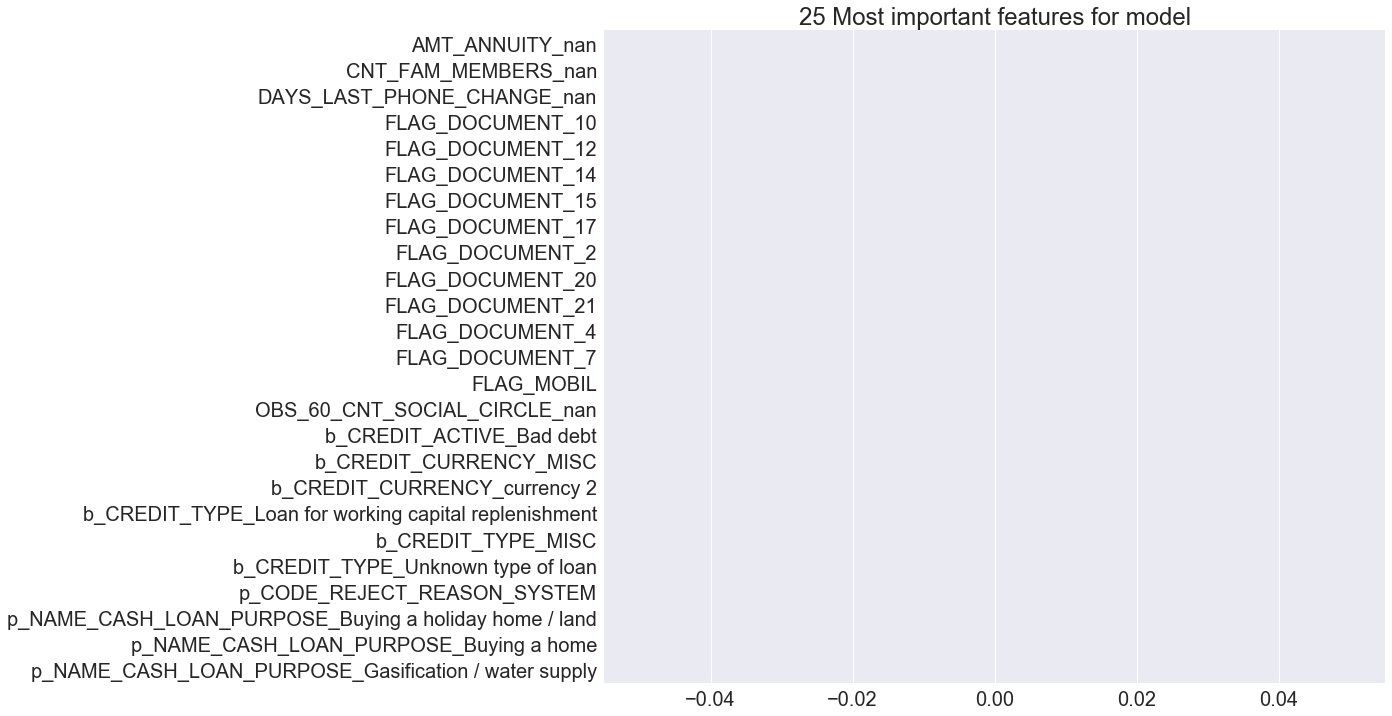

In [58]:
# Setup Extra Trees model
et_model = ExtraTreesClassifier()
et_model.fit(train_x[:10000], train_y[:10000])

# Get important features
x, y = (list(x) for x in zip(*sorted(zip(et_model.feature_importances_, train_x.columns), 
                                                            reverse = False)))

### Styling
sns.set(font_scale=2)
plt.figure(figsize=(14, 12))
plt.title("25 Most important features")

# Plot important features
_ = sns.barplot(x[-25:], y[-25:])

### Unimportant features

In [ ]:
# Setup Extra Trees model
et_model = ExtraTreesClassifier()
et_model.fit(train_x[:10000], train_y[:10000])

# Get important features
x, y = (list(x) for x in zip(*sorted(zip(et_model.feature_importances_, train_x.columns), 
                                                            reverse = False)))

### Styling
sns.set(font_scale=2)
plt.figure(figsize=(14, 12))
plt.title("25 Least important features")

# Plot important features
_ = sns.barplot(x[:25], y[:25])

### Predictions and save to CSV

In [54]:
pd.DataFrame({
    "SK_ID_CURR": test_id,
    "TARGET": sub_preds
}).to_csv("../submissions/kisil_5_folds_my_params.csv", index=False)